# Clustering_Supermarket_Customer_Data
In today's exercise, we are exploring using kmeans from scikit-learn to cluster supermarket data

###  Shopper Analytics - Customer Segmentation & Category Associations
We first import the necessary modules and files for analysis.

In [5]:
#Modules necessary for our project
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
%matplotlib inline

#Changing directory to where our data is, and where we want stuff to go.
print(os.getcwd())
os.chdir(r'C:\Users\Amir\Documents\DATA SCIENCE\Projects\Supermarket_Clusters_Indo')
print(os.getcwd())

#Importing data
s2_product_df = pd.read_csv('s2_product_master.csv',index_col=0)
s2_trans_df = pd.read_csv('s2_transaction_data.csv',index_col=0)

C:\Users\Amir\Documents\DATA SCIENCE\Projects\Supermarket_Clusters_Indo
C:\Users\Amir\Documents\DATA SCIENCE\Projects\Supermarket_Clusters_Indo


### Examining the data, and joining them into a single dataframe.
Next, we examine the contents of our dataframes to see what kind of data we are dealing with.
<br>
For exploratory data analysis, EDA, we use the head() and Tail() functions to browse the contents, the info() function to see the column data types, and the describe column to get summary statistcs.

In [6]:
#Browsing through data
#head() and tails() shows the top and bottom rows
#info() tells me the data types, 
#describes() gives me summary statistics about numerical columns

print("s2_product_master file\nHEAD")
print(s2_product_df.head())
print("TAIL")
print(s2_product_df.tail())
print("INFO")
print(s2_product_df.info())
print("DESCRIBE")
print(s2_product_df.describe())

print("\ns2_transaction_data file\nHEAD")
print(s2_trans_df.head())
print("TAIL")
print(s2_trans_df.tail())
print("INFO")
print(s2_trans_df.info())
print("DESCRIBE")
print(s2_trans_df.describe())

s2_product_master file
HEAD
   product_id product_lvl1_cat_desc product_lvl2_cat_desc
0         265               Alcohol                  Beer
1        1255               Alcohol                  Beer
2        2425               Alcohol                  Beer
3        4343               Alcohol                  Beer
4        4709               Alcohol                  Beer
TAIL
       product_id product_lvl1_cat_desc product_lvl2_cat_desc
10743       53829               PetCare          SmallAnimals
10744       62622               PetCare          SmallAnimals
10745       66107               PetCare          SmallAnimals
10746       69773               PetCare          SmallAnimals
10747      120588               PetCare          SmallAnimals
INFO
<class 'pandas.core.frame.DataFrame'>
Int64Index: 10748 entries, 0 to 10747
Data columns (total 3 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   product_id             1074

Now, we join the 2 dataframes on the sales_product and product_id columns repectively, and verify the contents.

In [7]:
#Joining data on 'sales_product' and 'product_id', since they share commmon values and describe the same variable.

s2_trans_df2 = s2_trans_df.merge(s2_product_df, how = 'left', left_on = 'sales_product', right_on = 'product_id')
s2_trans_df2.drop(['sales_product'], axis=1, inplace=True)

print("s2_trans_df2 file\nHEAD")
print(s2_trans_df2.head())
print("TAIL")
print(s2_trans_df2.tail())
print("INFO")
print(s2_trans_df2.info())
print("DESCRIBE")
print(s2_trans_df2.describe())

s2_trans_df2 file
HEAD
   sales_receipt  sales_customer  sales_date_id  product_id  \
0      203722145             569       20180102       30763   
1      203722145             569       20180102      112415   
2      203722145             569       20180102       49480   
3      203722145             569       20180102      130287   
4      203722145             569       20180102       68306   

  product_lvl1_cat_desc   product_lvl2_cat_desc  
0         FoodCommodity              JarredFood  
1          BabyAndChild            ToysLearning  
2                Frozen  BreadBagelsandPancakes  
3          FreshProduce          TropicalFruits  
4          BabyAndChild            BabyPersonal  
TAIL
       sales_receipt  sales_customer  sales_date_id  product_id  \
49995      205776308             515       20180914       11174   
49996      205776308             515       20180914       23356   
49997      205776308             515       20180914      103770   
49998      205776308     

### Preparing the data for kmeans clustering
For today's exercise we are using kmeans to cluster our data. 
<br>
For this to work, we need to convert the object data columns into numerical values using the get dummies, since kmeans only works with numerical data.
<br>
We also drop the sales_customer, sales_date_id, and product_id columns, as we are not using them in the analysis.

In [8]:
#Transforming the product_lvl1_cat_desc, and product_lvl2_cat_desc columns into numerical data using get_dummies
#Get_dummies makes every unique value in the categorical column into its own column
#It then assigns a 1 or 0 for each row depending if that value existed in that row prior to the transformation

s2_trans_encoded = pd.get_dummies(s2_trans_df2.drop(['sales_customer', 'sales_date_id', 'product_id'], axis=1), 
                                  prefix=['lvl1','lvl2'])

print("s2_trans_encoded file\nHEAD")
print(s2_trans_encoded.head())
print("TAIL")
print(s2_trans_encoded.tail())
print("INFO")
print(s2_trans_encoded.info())
print("DESCRIBE")
print(s2_trans_encoded.describe())

s2_trans_encoded file
HEAD
   sales_receipt  lvl1_Alcohol  lvl1_BabyAndChild  lvl1_Bakery  lvl1_Beauty  \
0      203722145             0                  0            0            0   
1      203722145             0                  1            0            0   
2      203722145             0                  0            0            0   
3      203722145             0                  0            0            0   
4      203722145             0                  1            0            0   

   lvl1_Beverages  lvl1_DairyAndChilled  lvl1_FoodCommodity  lvl1_FoodImpulse  \
0               0                     0                   1                 0   
1               0                     0                   0                 0   
2               0                     0                   0                 0   
3               0                     0                   0                 0   
4               0                     0                   0                 0   

   lvl1_Fre

Next, we group by the sales_receipt column, and aggregate by sum to get how much of each category was perchased in each transaction.

In [9]:
#Since the data is presented with every item from every receipt as its own row, we aggregate by receipt.
#This makes every row a sum of purchases in a receipt, allowing us to cluster by what was in each receipt.

s2_trans_by_receipts = s2_trans_encoded.groupby('sales_receipt').agg('sum')

print("s2_trans_by_receipts file\nHEAD")
print(s2_trans_by_receipts.head())
print("TAIL")
print(s2_trans_by_receipts.tail())
print("INFO")
print(s2_trans_by_receipts.info())
print("DESCRIBE")
print(s2_trans_by_receipts.describe())

s2_trans_by_receipts file
HEAD
               lvl1_Alcohol  lvl1_BabyAndChild  lvl1_Bakery  lvl1_Beauty  \
sales_receipt                                                              
203722145                 0                  3            0            1   
203722732                 0                  1            0            0   
203722795                 0                  0            0            0   
203723509                 1                  0            0            0   
203724266                 0                  0            0            0   

               lvl1_Beverages  lvl1_DairyAndChilled  lvl1_FoodCommodity  \
sales_receipt                                                             
203722145                   0                     3                   3   
203722732                   1                     2                   0   
203722795                   3                     1                   7   
203723509                   1                     0          

Since the columns starting with lvl2 in their names are just breakdowns of the lvl1 columns, we select only the lvl1 columns for use in our kmeans clustering.

In [10]:
'''
Since we are clusteering based on purchasing habits, and the variables in the lvl2 column are just details about the
variables in the product_lvl2_cat_desc column are just details abouts the product_lvl1_cat_desc column, 
we chose to only use the lvl1 dummies for kmeans.
'''

s2_trans_for_kmeans = s2_trans_by_receipts.iloc[:,:15]

print("s2_trans_for_kmeans file\nHEAD")
print(s2_trans_for_kmeans.head())
print("TAIL")
print(s2_trans_for_kmeans.tail())
print("INFO")
print(s2_trans_for_kmeans.info())
print("DESCRIBE")
print(s2_trans_for_kmeans.describe())

s2_trans_for_kmeans file
HEAD
               lvl1_Alcohol  lvl1_BabyAndChild  lvl1_Bakery  lvl1_Beauty  \
sales_receipt                                                              
203722145                 0                  3            0            1   
203722732                 0                  1            0            0   
203722795                 0                  0            0            0   
203723509                 1                  0            0            0   
203724266                 0                  0            0            0   

               lvl1_Beverages  lvl1_DairyAndChilled  lvl1_FoodCommodity  \
sales_receipt                                                             
203722145                   0                     3                   3   
203722732                   1                     2                   0   
203722795                   3                     1                   7   
203723509                   1                     0           

We now plot the columns we have selected, in order to get an idea of their distribution.

C:\Users\Amir\Anaconda3\lib\site-packages\seaborn\distributions.py:369: UserWarning: Default bandwidth for data is 0; skipping density estimation.
  warnings.warn(msg, UserWarning)
C:\Users\Amir\Anaconda3\lib\site-packages\seaborn\distributions.py:369: UserWarning: Default bandwidth for data is 0; skipping density estimation.
  warnings.warn(msg, UserWarning)
C:\Users\Amir\Anaconda3\lib\site-packages\seaborn\distributions.py:369: UserWarning: Default bandwidth for data is 0; skipping density estimation.
  warnings.warn(msg, UserWarning)
C:\Users\Amir\Anaconda3\lib\site-packages\seaborn\distributions.py:369: UserWarning: Default bandwidth for data is 0; skipping density estimation.
  warnings.warn(msg, UserWarning)
C:\Users\Amir\Anaconda3\lib\site-packages\seaborn\distributions.py:369: UserWarning: Default bandwidth for data is 0; skipping density estimation.
  warnings.warn(msg, UserWarning)
C:\Users\Amir\Anaconda3\lib\site-packages\seaborn\distributions.py:369: UserWarning: Default ba

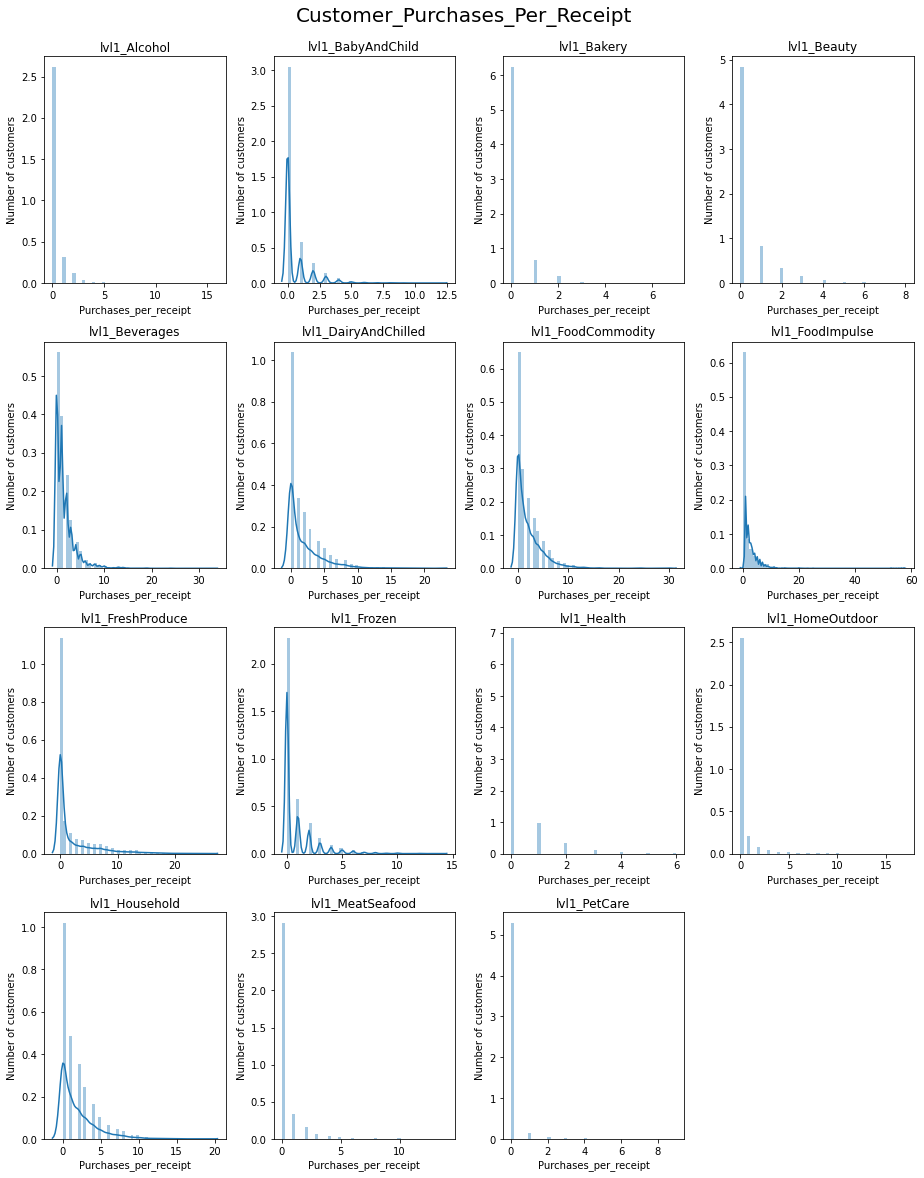

In [11]:
'''
This is a template I came up with to L graphs in an r_max*c_max subplot, where r_max is the number of subplot rows, 
and c_max is the number of columns. Here I set it up such that it uses the seaborn distplot to plot the distributions of
all the lvl1 columns in a 4*4 grid.

The purpose here is to check how skewed the data is from a normal distribution.
'''

temp_df = s2_trans_for_kmeans

r_max = np.int(np.ceil(np.sqrt(len(temp_df.columns))))
c_max = np.int(np.ceil(np.sqrt(len(temp_df.columns))))
fig, ax = plt.subplots(r_max,c_max)
fig.set_size_inches(13,16)
r=0
c=0
for i in temp_df.columns:
    if c==c_max-1:
        axe=ax[r, c]
        sns.distplot(temp_df[i], ax=axe)
        '''axe.text(0.7, 0.8, 'Mean: {}\nSTD: {}'.format(round(np.mean(weather_interval_5[i]['mean_temp']),2),
                                                        round(np.std(weather_interval_5[i]['mean_temp']),2)), 
                 transform=axe.transAxes)'''
        axe.set_xlabel('Purchases_per_receipt')
        axe.set_ylabel('Number of customers')
        axe.set_title(i)
        r+=1
        c=0
    else:
        axe=ax[r, c]
        sns.distplot(temp_df[i], ax=axe)
        '''axe.text(0.7, 0.8, 'Mean: {}\nSTD: {}'.format(round(np.mean(weather_interval_5[i]['mean_temp']),2),
                                                        round(np.std(weather_interval_5[i]['mean_temp']),2)), 
                 transform=axe.transAxes)'''
        axe.set_xlabel('Purchases_per_receipt')
        axe.set_ylabel('Number of customers')
        axe.set_title(i)
        c+=1

fig.suptitle('Customer_Purchases_Per_Receipt', y=1.02, fontsize=20)
fig.tight_layout()
fig.delaxes(ax[-1,-1])
#fig.delaxes(ax[-1,-2])
#plt.style.use('dark_background')
#plt.savefig('temp_hist.png', bbox_inches = 'tight')
plt.show()

For kmeans clustering, it is ideal that the data fulfills the following conditions:
 - The data should not be skewed
 - The variables should have the same mean
 - The variables shoule have the same variance

To fulfill these condition, we use the log10() function from numpy, 
and import the StandardScaler() function. We also import KMeans here to cluster our data.

In [12]:
#We import StandardScaler to help scale our data, and KMeans to later perform clustering

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

By applying log10() to our dataframe, we reduce the skew of our data. 
<br>
We then apply StandardScaler() which scales our data such that all the variable means are approximately 0, 
and the standard deviations are approximately 1.
<br>
Since the transformation changes our dataframe into a numpy array, we have to apply DataFrame() to change it back into a dataframe.
<br>
We use head() to examine the transformed data, and describe() to verify that the means and standard deviations are as desired.

In [13]:
'''We apply log to our data in the form of log10(dataframe + 1). 
This reduces the skew of the data, hopefully making it slightly more normal for our kmeans
We then intitialise StandardScaler, and fit our data to it to scale our mean to ~0 and std to ~1'''

s2_trans_log_receipts = np.log10(s2_trans_for_kmeans+1)
scaler = StandardScaler()
scaler.fit(s2_trans_log_receipts)
s2_trans_norm_receipts = scaler.transform(s2_trans_log_receipts)
s2_trans_norm_receipts_df = pd.DataFrame(s2_trans_norm_receipts,columns=s2_trans_for_kmeans.columns)

print("HEAD")
print(s2_trans_norm_receipts_df.head())
print("DESCRIBE")
print(s2_trans_norm_receipts_df.describe())

HEAD
   lvl1_Alcohol  lvl1_BabyAndChild  lvl1_Bakery  lvl1_Beauty  lvl1_Beverages  \
0     -0.403564           2.308594    -0.366943     1.134766       -1.068359   
1     -0.403564           0.874512    -0.366943    -0.503418       -0.027802   
2     -0.403564          -0.558594    -0.366943    -0.503418        1.012695   
3      1.420898          -0.558594    -0.366943    -0.503418       -0.027802   
4     -0.403564          -0.558594    -0.366943    -0.503418       -0.027802   

   lvl1_DairyAndChilled  lvl1_FoodCommodity  lvl1_FoodImpulse  \
0              0.851074            0.756836         -0.755859   
1              0.480225           -1.042969         -0.755859   
2             -0.042450            1.656250         -0.755859   
3             -0.936523           -0.143066         -0.755859   
4              0.851074            0.383057          1.791016   

   lvl1_FreshProduce  lvl1_Frozen  lvl1_Health  lvl1_HomeOutdoor  \
0           1.263672     1.202148    -0.439697         

Now that we are sure that the variables means and standard deviations are the same, we plot their distributions again to check for skew.

C:\Users\Amir\Anaconda3\lib\site-packages\seaborn\distributions.py:369: UserWarning: Default bandwidth for data is 0; skipping density estimation.
  warnings.warn(msg, UserWarning)
C:\Users\Amir\Anaconda3\lib\site-packages\seaborn\distributions.py:369: UserWarning: Default bandwidth for data is 0; skipping density estimation.
  warnings.warn(msg, UserWarning)
C:\Users\Amir\Anaconda3\lib\site-packages\seaborn\distributions.py:369: UserWarning: Default bandwidth for data is 0; skipping density estimation.
  warnings.warn(msg, UserWarning)
C:\Users\Amir\Anaconda3\lib\site-packages\seaborn\distributions.py:369: UserWarning: Default bandwidth for data is 0; skipping density estimation.
  warnings.warn(msg, UserWarning)
C:\Users\Amir\Anaconda3\lib\site-packages\seaborn\distributions.py:369: UserWarning: Default bandwidth for data is 0; skipping density estimation.
  warnings.warn(msg, UserWarning)
C:\Users\Amir\Anaconda3\lib\site-packages\seaborn\distributions.py:369: UserWarning: Default ba

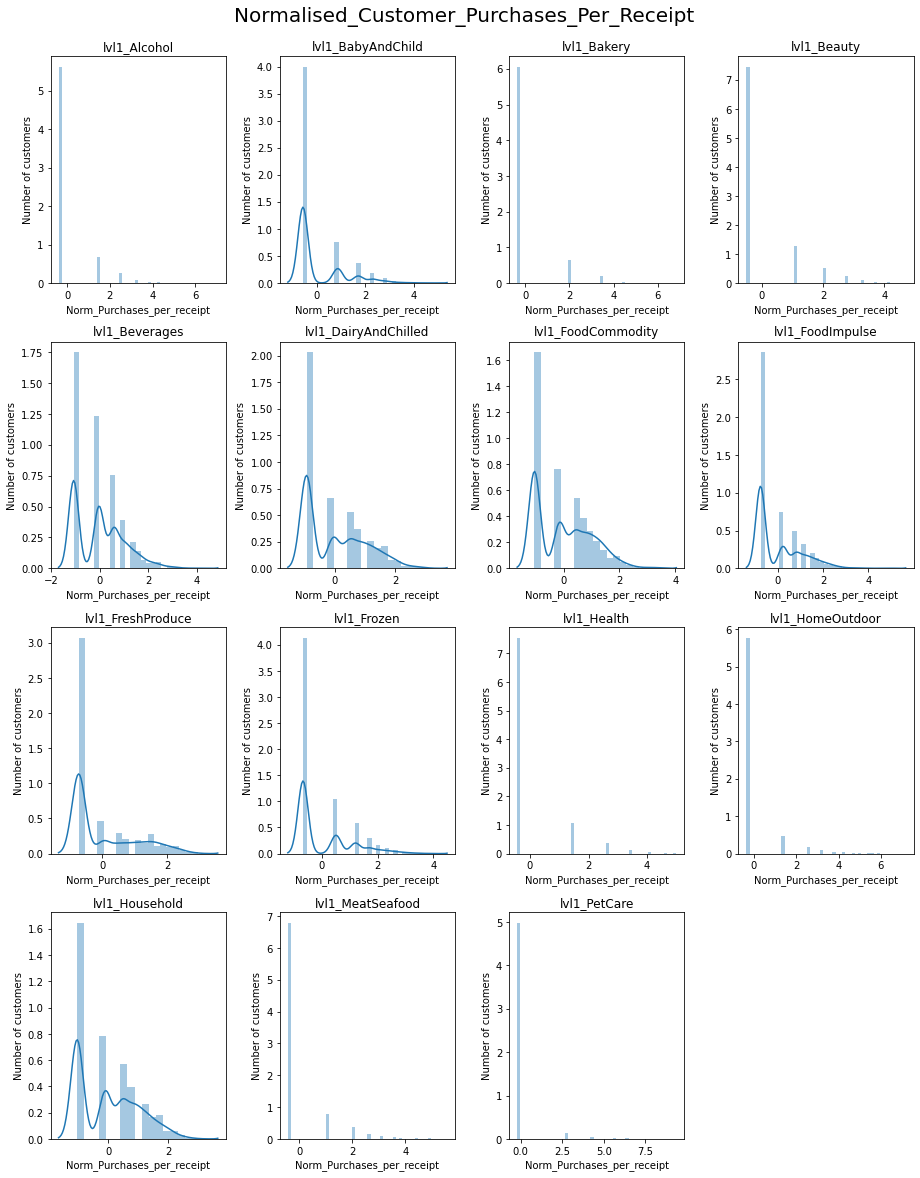

In [14]:
#We again reuse my template to check for skewness of the now transformed data.

temp_df = s2_trans_norm_receipts_df.iloc[:,:16]

r_max = np.int(np.ceil(np.sqrt(len(temp_df.columns))))
c_max = np.int(np.ceil(np.sqrt(len(temp_df.columns))))
fig, ax = plt.subplots(r_max,c_max)
fig.set_size_inches(13,16)
r=0
c=0
for i in temp_df.columns:
    if c==c_max-1:
        axe=ax[r, c]
        sns.distplot(temp_df[i], ax=axe)
        '''axe.text(0.7, 0.8, 'Mean: {}\nSTD: {}'.format(round(np.mean(weather_interval_5[i]['mean_temp']),2),
                                                        round(np.std(weather_interval_5[i]['mean_temp']),2)), 
                 transform=axe.transAxes)'''
        axe.set_xlabel('Norm_Purchases_per_receipt')
        axe.set_ylabel('Number of customers')
        axe.set_title(i)
        r+=1
        c=0
    else:
        axe=ax[r, c]
        sns.distplot(temp_df[i], ax=axe)
        '''axe.text(0.7, 0.8, 'Mean: {}\nSTD: {}'.format(round(np.mean(weather_interval_5[i]['mean_temp']),2),
                                                        round(np.std(weather_interval_5[i]['mean_temp']),2)), 
                 transform=axe.transAxes)'''
        axe.set_xlabel('Norm_Purchases_per_receipt')
        axe.set_ylabel('Number of customers')
        axe.set_title(i)
        c+=1

fig.suptitle('Normalised_Customer_Purchases_Per_Receipt', y=1.02, fontsize=20)
fig.tight_layout()
fig.delaxes(ax[-1,-1])
#fig.delaxes(ax[-1,-2])
#plt.style.use('dark_background')
#plt.savefig('temp_hist.png', bbox_inches = 'tight')
plt.show()

Unfortunately the distribution are still not really normal.
Nonetheless, the data is less skewed, and the other 2 conditions have been met, 
so we are reasonably confident in performing kmeans.


### Choosing the number of clusters , and performing kmeans clustering

First, we select for the number of clusters using the elbow criterion. 
What this entails is that we apply kmeans acrow a range of cluster values, 
and plot the sum-of-squared-errors (SSE) against the number of clusters.
The selection is subjective, 
but normally one chooses the point at which the decrease in SSE between increases in clusters is realatively small.
Ultamately, plotting the data and comparing between clusters is ideal to confirm that the clusters are different enough.

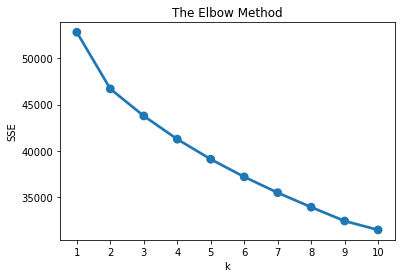

In [15]:
'''
The method for choosing k,  the number of clusters, is by plotting the SSE, called distortion, and noting the turning point.
This is the point where the decrease in distortion starts to level off, 
and subsequent decreases being significantly smaller than before the turning point.
This turning point becomes our candidate for k. 
Of note that the elbow method is not absolute, and running kmeans for k-1, k, 
and k+1 and plotting their clusters would allow for a better understanding whether the differnces want the extra clusters.
'''

sse = {}
for k in range(1,11):
    kmeans = KMeans(n_clusters=k, random_state=1)
    kmeans.fit(s2_trans_norm_receipts_df)
    sse[k] = kmeans.inertia_
    
plt.title('The Elbow Method')
plt.xlabel('k'); plt.ylabel('SSE')
sns.pointplot(x=list(sse.keys()), y=list(sse.values()))
plt.show()

Looking at the data, 2 looks pbvious, but the difference from 2 to 3, 
and 3 to 4 looks difference enough that we can try for 3 clusters.
<br>
We now apply the kmeans algorithm, and use assign() to attach these labels back s2_trans_by_receipts, 
the DataFrame which we grouped by the column sales_receipt.

In [16]:
'''
We apply the kmeans algorithm, and assign these values back to our group by receipt dataframe.
We then group by cluster labels to see the properties of each cluster
'''

kmeans = KMeans(n_clusters = 3, random_state = 1)
kmeans.fit(s2_trans_norm_receipts_df)
cluster_labels = kmeans.labels_
s2_trans_receipt_kmeans = s2_trans_by_receipts.assign(Cluster = cluster_labels)
s2_trans_group_means = s2_trans_receipt_kmeans.groupby('Cluster').mean()
print("HEAD")
print(s2_trans_group_means.head())

HEAD
         lvl1_Alcohol  lvl1_BabyAndChild  lvl1_Bakery  lvl1_Beauty  \
Cluster                                                              
0            0.213415           0.262195     0.091463     0.439024   
1            0.394881           0.424132     0.463437     0.392139   
2            0.255752           0.589823     0.040708     0.384956   

         lvl1_Beverages  lvl1_DairyAndChilled  lvl1_FoodCommodity  \
Cluster                                                             
0              1.658537              1.536585            3.097561   
1              1.727605              4.306216            3.185558   
2              1.551327              0.730531            1.473451   

         lvl1_FoodImpulse  lvl1_FreshProduce  lvl1_Frozen  ...  \
Cluster                                                    ...   
0                0.743902           0.823171     0.408537  ...   
1                2.408592           5.602377     1.748629  ...   
2                0.851327         

### Examining our clusters
We now filter out the lvl1 and lvl2 columns, so that we can conveniently reference them during our analysis.

In [17]:
#To allow ease of looking at the lvl1 and lvl2 columns, we assigned their column name to seperate lists
filter_lvl1 = [col for col in s2_trans_group_means if col.startswith('lvl1')]
filter_lvl2 = [col for col in s2_trans_group_means if col.startswith('lvl2')]
print(s2_trans_group_means[filter_lvl1])

         lvl1_Alcohol  lvl1_BabyAndChild  lvl1_Bakery  lvl1_Beauty  \
Cluster                                                              
0            0.213415           0.262195     0.091463     0.439024   
1            0.394881           0.424132     0.463437     0.392139   
2            0.255752           0.589823     0.040708     0.384956   

         lvl1_Beverages  lvl1_DairyAndChilled  lvl1_FoodCommodity  \
Cluster                                                             
0              1.658537              1.536585            3.097561   
1              1.727605              4.306216            3.185558   
2              1.551327              0.730531            1.473451   

         lvl1_FoodImpulse  lvl1_FreshProduce  lvl1_Frozen  lvl1_Health  \
Cluster                                                                  
0                0.743902           0.823171     0.408537     0.286585   
1                2.408592           5.602377     1.748629     0.307130   
2      

We use a bar plot to visualise the difference between the clusters

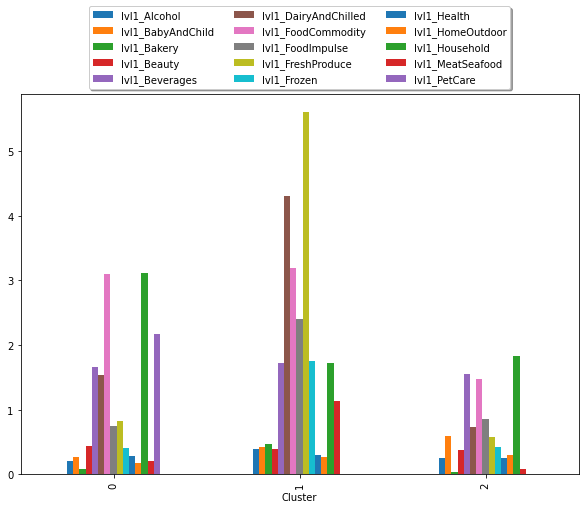

In [18]:
#We plot the clusters, take note of their differences, and make guesses about the nature of these clusters.

ax = s2_trans_group_means[filter_lvl1].plot(kind='bar',figsize=(10,7))
#ax.set_ylim([0,0.25])
ax.legend(loc='lower center', bbox_to_anchor=(0.5, 1),
          ncol=3, fancybox=True, shadow=True)
plt.show()

From the graph, we notice that the clusters have the following differences:
 - cluster 0: More household and PetCare
 - cluster 1: More Bakery, DairyAndChilled, FoodImpulse, FreshProduce, Frozen, and MeatSeafood
 - cluster 2: More BabyAndChild, lesser FoodCommodity.
    
From this, we can guess that the cluster 0 is composed of pet owners, 
cluster 1 is composed of generic grocery shoppers, and cluster 2 is composed of parents with a new baby.
We can further investigate into their difference by printing out the top 20 purchases from each category.

In [19]:
#We then print out the top lvl2 columns from our clusters to check our guesses from our plots

for i in range(3):
    temp = s2_trans_group_means.iloc[i,:][filter_lvl2]
    print(f"CLUSTER {i}")
    print(temp.sort_values(ascending=False)[:20])

CLUSTER 0
lvl2_Cat                     1.426829
lvl2_Cleaning                1.030488
lvl2_CannedFood              0.878049
lvl2_Paper                   0.713415
lvl2_CookingIngredients      0.682927
lvl2_MilkButterEggs          0.646341
lvl2_Dog                     0.646341
lvl2_Laundry                 0.640244
lvl2_SoftDrinks              0.640244
lvl2_HomeBaking              0.585366
lvl2_NoodlesPastaAndRice     0.384146
lvl2_Yoghurt                 0.329268
lvl2_Dishwashing             0.329268
lvl2_HotDrinks               0.323171
lvl2_PersonalCare            0.298780
lvl2_SoftVegetables          0.292683
lvl2_UHTMilkMilkPowder       0.292683
lvl2_Cheese                  0.286585
lvl2_Snacks                  0.280488
lvl2_CookingSaucesAndKits    0.262195
Name: 0, dtype: float64
CLUSTER 1
lvl2_SoftVegetables         2.287020
lvl2_MilkButterEggs         1.746801
lvl2_HardVegetables         1.106033
lvl2_FreshMeat              0.893967
lvl2_Yoghurt                0.882998
lvl2_Snacks

Here the differences are made clearer:
 - Cluster 0: Cat products being purchased far more than the other products, 
followed by Cleaning perhaps to represent the added house cleaning involved in pet ownership.
 - Cluster 1: Vegetables and MilkButterEggs takes prime spot as would be expected from grocery shopping.
 - Cluster 2: The top purchases are somewhat irrelavent to our prediction, but the presence of UHTMilkMilkPowder, 
DiaperingAndPottyTraining, BabyPersonal seem to support out guess at new parents.

Thus concludes our exercise in using KMeans to cluster customer data.

